In [23]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import warnings

from deepemogp import feature_extractor
from deepemogp.signal import physio as physio
from deepemogp import datasets as datasets
from deepemogp.signal import behavior as behavior

In [24]:
warnings.simplefilter(action="ignore", category=FutureWarning)
scaler = StandardScaler()

In [25]:
show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f3)
hr_ = physio.HR(f3)
pupil_ = behavior.PUPIL(f3)


# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'45'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        if s.name == 'HR':
            list_hr_test = s.raw[0]['data']
            s.preprocess(show=show, useneurokit=True)
            s.feature_ext.extract_feat(s,show=show)

        else:
            s.feature_ext.extract_feat_without_preprocess(s, show=show)

for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading HR for subject 45 and all sessions from dataset FEAR
>> Loading EDA for subject 45 and all sessions from dataset FEAR
>> Loading PUPIL for subject 45 and all sessions from dataset FEAR
>> Processing HR ... using neurokit


/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._me

>> Extracting mean features from HR signal, adopting (1, 0) window ...
>> Processing EDA ...
>> Extracting mean features from EDA signal, adopting (1, 0) window ...
>> Extracting mean features from PUPIL signal, adopting (1, 0) window ...


In [26]:
TRIAL = 160
hr = np.array(hr_data)
hr = hr.reshape((TRIAL, int(hr.shape[0] / TRIAL * hr.shape[1])))
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0] / TRIAL * pupil.shape[1])))
eda = np.array(eda_data)
eda = eda.reshape((TRIAL, int(eda.shape[0] / TRIAL * eda.shape[1])))

In [27]:
trial_i = 113
index = np.arange(6)
hr_trial = hr[trial_i]
eda_trial = eda[trial_i]

coords_ = {'time':index, 'hr_': hr_trial, 'eda_':eda_trial}
coords_

{'time': array([0, 1, 2, 3, 4, 5]),
 'hr_': array([141.8857144 , 158.83336858, 138.11937399, 117.17355808,
        128.07816207, 149.82723018]),
 'eda_': array([0.0937623 , 0.09504591, 0.25697509, 0.29961651, 0.2227497 ,
        0.35046481])}

In [28]:
with pm.Model(coords=coords_) as rolling:
    sigma_alpha = pm.Exponential("sigma_alpha", 50.0)
    sigma_beta = pm.Exponential("sigma_beta", 50.0)

    alpha = pm.GaussianRandomWalk(
        "alpha", sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims="time"
    )
    beta = pm.GaussianRandomWalk(
        "beta", sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims="time"
    )
    regression = alpha + beta * hr

    # Assume eda data are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal("sd", sigma=0.1)
    likelihood = pm.Normal("y", mu=regression, sigma=sd, observed=eda)

In [29]:
graph_rolling = pm.model_to_graphviz(rolling)
graph_rolling.view('rolling_regr')

'rolling_regr.pdf'

In [30]:
with rolling:
    trace = pm.sample(tune=2000, target_accept=0.9)

/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
qt5ct: using qt5ct plugin
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimety

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 254 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aeppl/joint_logprob.py:130: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [31]:
with rolling:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

Sampling: [y]


In [32]:
eda_pred = posterior_predictive.posterior_predictive['y']
eda_pred

<xarray.DataArray 'y' (chain: 2, draw: 1000, y_dim_0: 160, y_dim_1: 6)>
array([[[[-0.3523712 ,  0.47746538,  1.23568773,  2.03599992,
           2.51387611,  2.05667809],
         [-0.46743234,  1.13271595, -0.46391583,  1.99708601,
           2.05527136,  1.65775381],
         [-1.17944721,  0.48728551,  0.93096924, -2.11544319,
           0.86796419, -0.18280123],
         ...,
         [ 2.00216262,  0.64900662,  2.11052003, -0.44869722,
           1.04038769,  2.04170837],
         [ 1.22658017,  0.75595633,  0.19065474,  1.51260067,
          -1.88262766,  2.16305158],
         [ 0.14945786,  1.39998079,  0.32780269,  3.69918425,
           1.32112935,  2.55945068]],

        [[-0.46511777,  0.91485803,  0.84449246,  0.75172286,
           1.82357489,  2.72587594],
         [ 0.38520192,  1.73778315,  1.58735791,  1.64476247,
           0.76729433,  0.99216856],
         [ 1.87414025, -0.40775869,  1.30823696,  1.40880819,
           2.05188994,  2.66273394],
...
         [-0.17782878,  0.33850759,  2.93965993,  1.05567792,
           2.65533317,  1.33554203],
         [ 0.18536914,  1.49793319,  1.21839729, -0.15306171,
           0.44187664,  3.32664754],
         [-0.63191348,  2.35897942,  0.58412045,  2.42480503,
           1.88259679,  2.83499026]],

        [[-0.80140793,  0.08345321,  0.42853305,  2.45220148,
           0.93357691,  1.87839433],
         [-0.94517719,  1.03788754,  2.75882428,  2.1838196 ,
          -0.10522192,  1.38014069],
         [-1.61036314, -0.09240871,  1.46191826,  3.37041744,
           2.67610243,  2.00605517],
         ...,
         [ 0.86618966,  0.44731651,  2.45745823,  0.58318893,
           3.38196108,  2.16422937],
         [ 0.58446255,  1.27783501,  1.53760043,  2.42894755,
           0.38235678, -2.17306951],
         [ 0.32032522, -0.26341086,  1.97016933,  4.48156294,
           0.49420446,  2.28057985]]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 ... 152 153 154 155 156 157 158 159
  * y_dim_1  (y_dim_1) int64 0 1 2 3 4 5

<AxesSubplot: xlabel='y / y'>

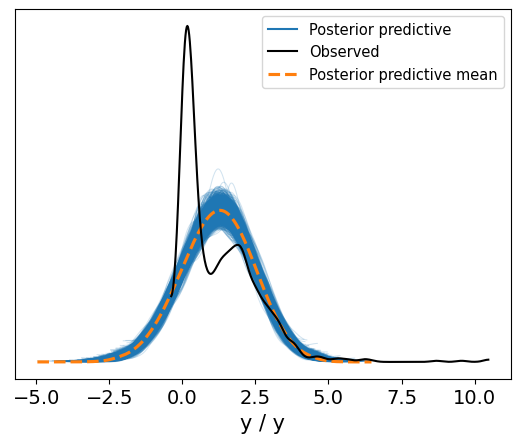

In [33]:
az.plot_ppc(posterior_predictive,)

In [34]:
eda_pred_mean = np.squeeze(stats.mode(eda_pred[0], keepdims=False)[0])[:,np.newaxis]

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mean_squared_error(eda, eda_pred_mean)

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
mean_absolute_error(coords_['eda_'], eda_pred_mean)

In [ ]:
final_df = pd.DataFrame()
